# Librerías

In [1]:
#Librerías Base
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [2]:
#Librerías de Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

In [3]:
#Librerías de Machine Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop

# Conexión al repositorio de datos

In [4]:
#Accedemos a Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calibraciones

In [5]:
#Cantidad de iteraciones en el entrenamiento
numero_de_iteraciones_al_entrenar = 10

In [64]:
#Calibración del learning rate
calibracion_lr = [0.1, 0.5, 0.01, 0.05]

#Valor óptimo
lr_calibrado = 0

In [65]:
#Calibración del tamaño de batch
calibracion_batch = [16, 32, 64, 128]

#Valor óptimo
batch_calibrado = 0

In [66]:
#Calibración de optimizador
calibracion_optimizador = [
'SGD(learning_rate=0.5)',
'SGD(learning_rate=0.5, momentum=0.3)',
'SGD(learning_rate=0.5, momentum=0.3, nesterov=True)',  
'Adam(learning_rate=0.5)',
'Adagrad(learning_rate=0.5)',
'RMSprop(learning_rate=0.5)'
]

#Valor óptimo
optimizador_calibrado = 0

# Funciones utilitarias

In [10]:
#Vamos a crear una función utilitaria para obtener el dataframe con los "accuracy" y "loss"
def obtener_df_loss_accuracy(array_calibracion, descripcion_calibracion, array_descripciones):
  #Fusionaremos uno tras otro para crear un único registro
  #Recordemos que al usar "axis = 1" estamos fusionandolas filas
  dfDescripcion = pd.concat(array_descripciones, axis = 1)

  #A cada "loss" y "accuracy" vamos a agregarle por encima su lr
  #Obtenemos el primer elemento del array de dataframes para obtener los títulos de las columnas
  columnas_loss_accuracy = array_descripciones[0].columns

  #Vamos a crear nuevas columnas a nuestro dataframe
  #Primero colocaremos las columnas que tendrán el nombre de cada lr usado, estos valores están en "array_lr"
  #Luego, para cada "descripcion_calibracion" vamos a colocarle las columnas "columnas_loss_accuracy"
  #Estas son columnas anidadas, las podemos crear con la función "MultiIndex" de Pandas
  #Por último, con el parámetro "names" colocamos el nombre para cada agrupación de columnas
  nuevas_columnas = pd.MultiIndex.from_product(
    [array_calibracion, columnas_loss_accuracy],
    names=[descripcion_calibracion, 'metricas']
  )

  #Colocamos las nuevas columnas a nuestro dataframe
  dfDescripcion.columns = nuevas_columnas
  dfDescripcion

  #Vamos a crear el dataframe de "loss"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (loss)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfLoss = dfDescripcion.xs('loss', level = 'metricas', axis = 1)
  
  #Vamos a crear el dataframe de "accuracy"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (accuracy)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfAccuracy = dfDescripcion.xs('accuracy', level = 'metricas', axis = 1)
  dfAccuracy

  #Devolvemos los dataframes
  return dfLoss, dfAccuracy

# Lectura de datos

In [67]:
#Leemos el dataset
df = pd.read_csv('/content/drive/MyDrive/Data/titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [68]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [69]:
df2 = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [70]:
df2.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [71]:
# Eliminamos registros con valores nulos
df2 = df2[df2['Age'].notna()]
df2 = df2[df2['Embarked'].notna()]

In [72]:
"""# Conversión de datos categóricos a datos numéricos"""

#Las redes neuronales solo entienden de numero, no de categorias
#Hay que transfomar las categorías a números


#Obtendremos columnas dummies, se creara una columna para cada categoria, si el registro pertenece a una categoria, se colocará 1
#A cada columna le coloca el prefijo que asignemos
#Notemos como la columna con data categórica se ha eliminado
df2 = pd.get_dummies(df2, columns = ['Pclass'], prefix='Pclass')
df2 = pd.get_dummies(df2, columns = ['Embarked'], prefix='Embarked')
df2 = pd.get_dummies(df2, columns = ['Sex'], prefix='Sex')
df2


,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,0,0,1,1,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,1,1,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,29.1250,0,0,1,0,1,0,1,0
886,0,27.0,0,0,13.0000,0,1,0,0,0,1,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,0,1,1,0
889,1,26.0,0,0,30.0000,1,0,0,1,0,0,0,1


In [73]:
# Escalamiento de los datos

#Las redes neuronales funcionan mejor con rangos de valores entre 0 y 1
#Vamos convertir los datos a un equivalente de datos entre 0 y 1

#Importamos el escalador
from sklearn.preprocessing import MinMaxScaler

#Instanciamos el escalador
mms = MinMaxScaler()

#Transformamos las columnas con el escalador

#En el dataframe 2, creamos una nueva columna llamada "Weight_mms" de datos escalados
df2['Age_mms'] = mms.fit_transform(df2[['Age']])
df2

#En el dataframe 2, creamos una nueva columna llamada "Height_mms" de datos escalados
df2['Fare_mms'] = mms.fit_transform(df2[['Fare']])
df2

df2['SibSp_mms'] = mms.fit_transform(df2[['SibSp']])
df2
df2['Parch_mms'] = mms.fit_transform(df2[['Parch']])
df2
del df2['SibSp']
del df2['Parch']
#Finalmente, dropeamos las columnas no escaladas
del df2['Age']
del df2['Fare']

#Mostramos el dataframe final
df2

,Survived,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Age_mms,Fare_mms,SibSp_mms,Parch_mms
0,0,0,0,1,0,0,1,0,1,0.271174,0.014151,0.2,0.000000
1,1,1,0,0,1,0,0,1,0,0.472229,0.139136,0.2,0.000000
2,1,0,0,1,0,0,1,1,0,0.321438,0.015469,0.0,0.000000
3,1,1,0,0,0,0,1,1,0,0.434531,0.103644,0.2,0.000000
4,0,0,0,1,0,0,1,0,1,0.434531,0.015713,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,0,0,1,0,1,0,1,0,0.484795,0.056848,0.0,0.833333
886,0,0,1,0,0,0,1,0,1,0.334004,0.025374,0.0,0.000000
887,1,1,0,0,0,0,1,1,0,0.233476,0.058556,0.0,0.000000
889,1,1,0,0,1,0,0,0,1,0.321438,0.058556,0.0,0.000000


In [74]:
df2.columns

Index(['Survived', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Age_mms',
       'Fare_mms', 'SibSp_mms', 'Parch_mms'],
      dtype='object')

# Definición de "features"

In [75]:
#Seleccionamos las columnas con las que trabajaremos
x = df2[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Age_mms',
       'Fare_mms', 'SibSp_mms', 'Parch_mms']].values
#x = df2[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
#       'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Age',
#       'Fare', 'SibSp', 'Parch']].values
x

array([[0.        , 0.        , 1.        , ..., 0.01415106, 0.2       ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.13913574, 0.2       ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01546857, 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.0585561 , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.0585561 , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01512699, 0.        ,
        0.        ]])

# Escalamiento de "Features"

In [52]:
'''#Importamos la librería para escalar
from sklearn.preprocessing import scale

#Escalamos
x = scale(x)
x
'''

'#Importamos la librería para escalar\nfrom sklearn.preprocessing import scale\n\n#Escalamos\nx = scale(x)\nx\n'

# Definición de "labels"

In [76]:
#Definimos los labels
y = df2['Survived'].values
y

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,

# División de los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)

In [77]:
#Dividimos los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [78]:
#Features de entrenamiento
x_train

array([[0.        , 1.        , 0.        , ..., 0.05074862, 0.2       ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02537431, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.06343578, 0.2       ,
        0.16666667],
       ...,
       [0.        , 0.        , 1.        , ..., 0.01541158, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.05074862, 0.2       ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.04396587, 0.        ,
        0.        ]])

In [79]:
#Labels de entrenamiento
y_train

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [80]:
#Features de validación
x_test

array([[0.        , 0.        , 1.        , ..., 0.01376068, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01533038, 0.2       ,
        0.16666667],
       [0.        , 1.        , 0.        , ..., 0.08115719, 0.2       ,
        0.33333333],
       ...,
       [0.        , 1.        , 0.        , ..., 0.06441171, 0.        ,
        0.16666667],
       [1.        , 0.        , 0.        , ..., 0.05182215, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01541158, 0.        ,
        0.        ]])

In [81]:
#Labels de validación
y_test

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0])

# Configuración del modelo

In [82]:
#Crearemos una función que construya la red neuronal
def definicion_red_neuronal():
  #Instaciamos un modelo de machine learning vacío con "Sequential"
  model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  model.add(Dense(1, input_shape=(12,), activation='sigmoid'))

  return model

# Calibracion de Learning Rate

In [83]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for lr in calibracion_lr:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=lr),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #Para evitar que el output de entrenamiento se muestre en pantalla desactivamos la variable "verbose"
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [84]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_lr, 'lr', array_descripciones)

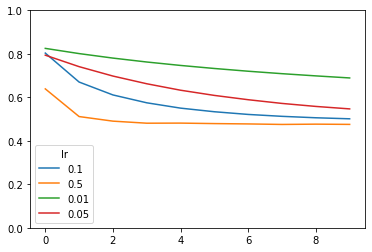

In [86]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

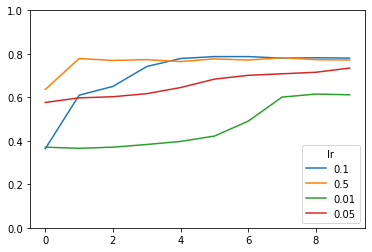

In [88]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [89]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
lr_calibrado = 0.05

# Calibración del Batch Size

In [90]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for batch in calibracion_batch:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=lr_calibrado),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" definimos el valor
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [91]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_batch, 'batch', array_descripciones)

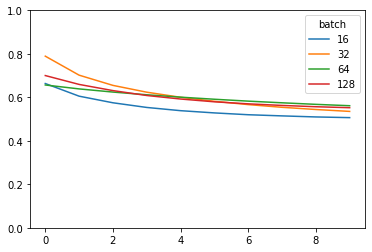

In [92]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

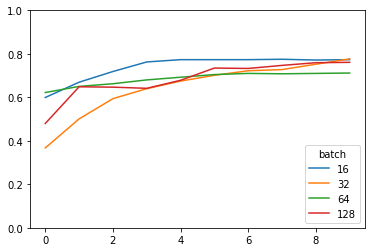

In [93]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [94]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
batch_calibrado = 32

# Calibración del optimizador

In [95]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for optimizador in calibracion_optimizador:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()
  
  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=eval(optimizador),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" colocamos 32, ya que fue lo que encontramos en la calibración anterior
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [96]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_optimizador, 'optimizador', array_descripciones)

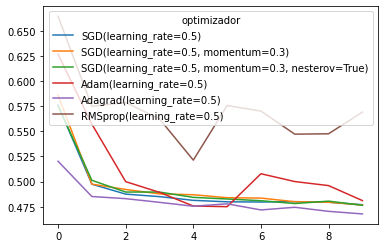

In [97]:
#Graficamos el dfLoss
dfLoss.plot()#ylim=(0,1))

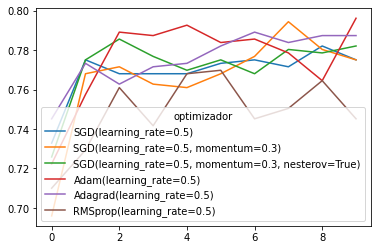

In [98]:
#Graficamos el dfLoss
dfAccuracy.plot()#ylim=(0,1))

In [99]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
optimizador_calibrado = Adam(lr=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Definicion del modelo

In [100]:
#Definimos el modelo con el inicializador calibrado
model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  #De aquí en adelante seguimos construyendo nuestra red neuronal
model.add(Dense(15, input_shape=(12,), activation='tanh'))
model.add(Dense(5, activation='tanh'))

  ### Esta es la capa de salida
model.add(Dense(1, activation='sigmoid'))



# Compilación del modelo

In [101]:
#Compilamos el modelo con el optimizador calibrado
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizador_calibrado,
  metrics=['accuracy']
)

# Entrenamiento del modelo

In [102]:
#Entrenamos el modelo enviándole los features (x_train) y labels (y_train) de entrenamiento, con el batch calibrado
model.fit(x_train, y_train, epochs=numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado)

Epoch 1/10
18/18 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.6573
Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5212 - accuracy: 0.7663
Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.7715
Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.7803
Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5249 - accuracy: 0.7873
Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7504
Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7645
Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5295 - accuracy: 0.7873
Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.7522
Epoch 10/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.7645


# Accuracy de entrenamiento (patrones encontrados en la data)

In [103]:
#Con los features (x_train) que usamos para entrenar el modelo, realizamos las predicciones (y_train_prediccion)
y_train_prediccion = model.predict(x_train).ravel()
y_train_prediccion

array([0.21506736, 0.21506736, 0.8816896 , 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.94990957,
       0.21506736, 0.21506736, 0.8816896 , 0.21506849, 0.21506736,
       0.21506748, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.8816896 , 0.21506736, 0.9499099 , 0.21506736, 0.21506736,
       0.8816896 , 0.21506736, 0.8816896 , 0.21506736, 0.21506736,
       0.21506742, 0.21506736, 0.21506736, 0.21506736, 0.9059552 ,
       0.21506736, 0.21506736, 0.9499098 , 0.21506736, 0.21506736,
       0.21506792, 0.8816896 , 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.9005261 , 0.94990975, 0.21506736, 0.94990927, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.9499097 , 0.21506736, 0.21506736, 0.21506

In [104]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_train_prediccion_binaria = y_train_prediccion > 0.5
y_train_prediccion_binaria

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True, False,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False, False,  True, False,
       False, False,

In [105]:
#Calculamos el error de entrenamiento
#INTERPRETACIÓN: El modelo encontró el 81.25% de los patrones existentes en la data
accuracy_score(y_train, y_train_prediccion_binaria)

0.7873462214411248

# Accuracy de uso (accuracy de predicción)

In [106]:
#Con los features (x_test) que no usamos para entrenar al modelo, realizamos las predicciones (y_test_prediccion)
y_test_prediccion = model.predict(x_test).ravel()
y_test_prediccion

array([0.21506736, 0.21506736, 0.91657245, 0.21506736, 0.9499096 ,
       0.21506736, 0.94990885, 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.9499099 , 0.21506736, 0.949909  ,
       0.21506736, 0.21506736, 0.21506736, 0.94990957, 0.9499097 ,
       0.21506736, 0.21506736, 0.9498832 , 0.8816896 , 0.21506736,
       0.8816896 , 0.9499053 , 0.94990957, 0.21506736, 0.8816896 ,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.9499099 ,
       0.21506736, 0.21506736, 0.94990736, 0.21506736, 0.8816896 ,
       0.94923973, 0.9499086 , 0.21506742, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.8816896 , 0.8816896 , 0.21506736,
       0.21506736, 0.9499097 , 0.21506736, 0.21506736, 0.8816896 ,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.94990957,
       0.21506736, 0.21506736, 0.21506736, 0.94990945, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.21506736,
       0.21506736, 0.21506736, 0.21506736, 0.21506736, 0.94990

In [107]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_test_prediccion_binaria = y_test_prediccion > 0.5
y_test_prediccion_binaria

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False,  True, False,  True, False, False, False,
        True,  True, False, False,  True,  True, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False,  True,  True, False, False,  True, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
       False, False,

In [108]:
#Calculamos el error
#INTERPRETACIÓN: El modelo al ser usado en un entorno productivo, de 100 casos acertará en 80 y se equivocará en 20 casos
accuracy_score(y_test, y_test_prediccion_binaria)

0.8111888111888111

# Análisis final

In [ ]:
#El modelo tiene un buen porcentaje de reconocimiento de patrones en los datos (78.7%)
#El modelo tiene un buen porcentaje de aciertos en nuestras predicciones (81%)
#La diferencia entre el porcentaje de reconocimiento de patrones (79%) y el porcentaje de aciertos (81%) es aceptable (2%)
#Como la diferencia es pequeña, estamos frente a un modelo que representa y predice muy bien la realidad de negocio
#Es un modelo que podemos usar en un entorno real de producción